### Question1

- Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?


Please note the average discount of entire order will be found, not just the each individual line item.  

### Importing Python Module and Establish SQL Connection


In [1]:
from importlib import reload

import numpy as np
import pandas as pd

import sqlite3
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

# Removing red warnings
import warnings
warnings.filterwarnings('ignore')

# Power Analysis
from statsmodels.stats.power import tt_ind_solve_power,ttest_power

#For tukey test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

#
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
figsize = (13,8)

import function as func

ip


### Function

In [2]:
def sql_to_dataframe(query):
    cur.execute(query)
    
    df = pd.DataFrame(cur.fetchall()) #Take results and create dataframe
    df.columns = [i[0] for i in cur.description]

    return df


### Creating  dataframe for discount quantity comparsion

Pulling from the database the order details.

In [3]:
query = """
            SELECT o.ID, ProductID, Quantity, Discount, UnitPrice
            FROM 'Order' as o
            JOIN 'OrderDetail' as od
            on o.ID = od.OrderID"""

df = sql_to_dataframe(query)
df.head()

,Id,ProductId,Quantity,Discount,UnitPrice
0,10248,11,12,0.0,14.0
1,10248,42,10,0.0,9.8
2,10248,72,5,0.0,34.8
3,10249,14,9,0.0,18.6
4,10249,51,40,0.0,42.4


Calculating the average percent discount for the entire.

In [4]:
# Adding the standard price
df['StandardPrice']= df.UnitPrice/(1- df.Discount)
# Line total
df['LineTotal'] = df.UnitPrice* df.Quantity
# Discounted Amount
df['StandardAmount'] = df.StandardPrice* df.Quantity
df.head()

,Id,ProductId,Quantity,Discount,UnitPrice,StandardPrice,LineTotal,StandardAmount
0,10248,11,12,0.0,14.0,14.0,168.0,168.0
1,10248,42,10,0.0,9.8,9.8,98.0,98.0
2,10248,72,5,0.0,34.8,34.8,174.0,174.0
3,10249,14,9,0.0,18.6,18.6,167.4,167.4
4,10249,51,40,0.0,42.4,42.4,1696.0,1696.0


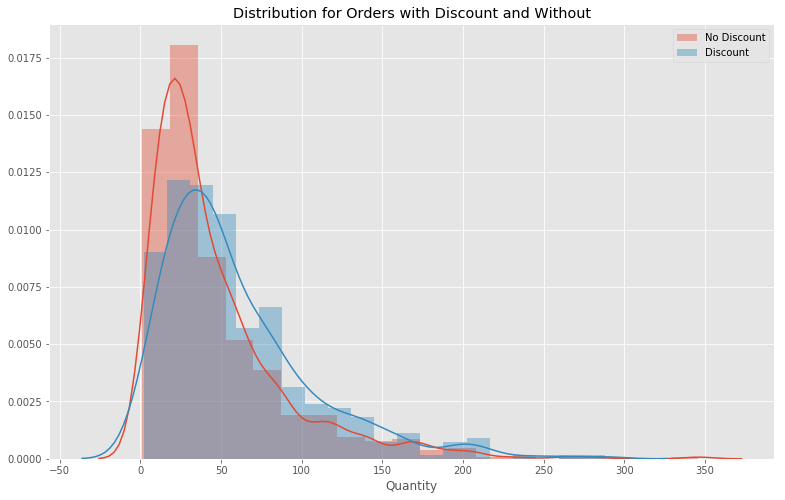

In [5]:
plt.figure(figsize=figsize);
columns = ['Quantity', 'LineTotal', 'StandardAmount', 'Discount']
orders_with_no_discount = df.loc[df.Discount == 0].groupby('Id')[columns].sum()
orders_with_discount = df.loc[df.Discount != 0].groupby('Id')[columns].sum()
sns.distplot(orders_with_no_discount.Quantity, bins = 20, label = 'No Discount');
sns.distplot(orders_with_discount.Quantity, bins = 20, label = 'Discount');
plt.title('Distribution for Orders with Discount and Without');
plt.legend();

In [6]:
orders_with_discount.Discount = (orders_with_discount.StandardAmount- orders_with_discount.LineTotal)/ orders_with_discount.StandardAmount 
df_orders = orders_with_discount.append(orders_with_no_discount)
hist, bin_edge = np.histogram(df_orders.Discount, bins= 3)
#bin_edge[1]=.0725
df_orders['BinnedDiscount'] = pd.cut(df_orders['Discount'], bin_edge)
df_orders.BinnedDiscount = df_orders.BinnedDiscount.astype(str)
df_orders.BinnedDiscount.loc[df_orders.BinnedDiscount == 'nan']= 'No Discount'
df_orders = df_orders.sort_values('Discount')
#type(orders_with_discount.BinnedDiscount[0])

In [7]:
df_orders.BinnedDiscount.value_counts()

No Discount        613
(0.0833, 0.167]    150
(0.167, 0.25]      144
(0.0, 0.0833]       86
Name: BinnedDiscount, dtype: int64

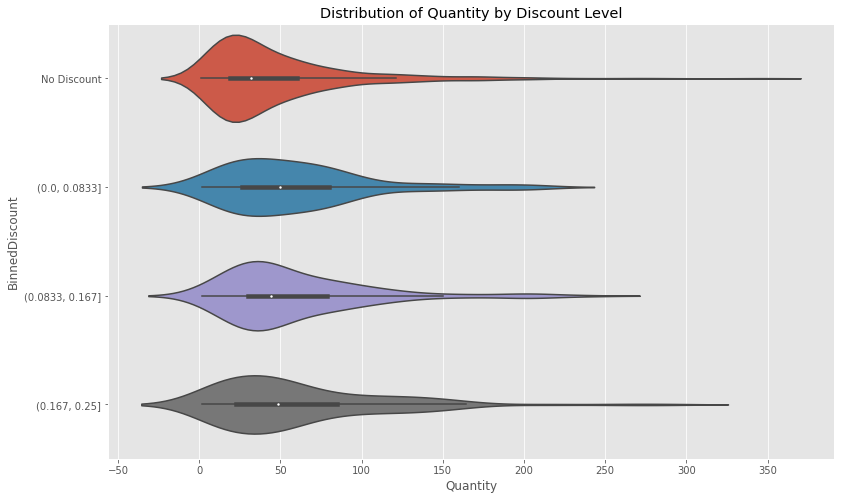

In [8]:
plt.figure(figsize= figsize)
plt.title('Distribution of Quantity by Discount Level')
sns.violinplot(x='Quantity', y= 'BinnedDiscount', data= df_orders);

#### Check for normality- Sharpio-Welk test

In [9]:
func.shapiro_normal(df_orders.Quantity)
#Overall quantity distribution

non normal


't 0.8211414813995361, p 7.739463034274397e-32'

In [10]:
func.shapiro_normal(df_orders.loc[df_orders.Discount == 0].Quantity)
#Discount quantity distribution

non normal


't 0.7845940589904785, p 1.1666289823246571e-27'

In [11]:
func.shapiro_normal(df_orders.loc[df_orders.Discount != 0].Quantity)
#No discount quantity distribution

non normal


't 0.8644283413887024, p 1.0952017721170508e-17'

In [12]:
for i in df_orders.BinnedDiscount.value_counts().index:
    print(i)
    print(func.shapiro_normal(df_orders.loc[df_orders.BinnedDiscount == i].Quantity))

No Discount
non normal
t 0.7845940589904785, p 1.1666289823246571e-27
(0.0833, 0.167]
non normal
t 0.8421576023101807, p 2.0802779637785207e-11
(0.167, 0.25]
non normal
t 0.8608901500701904, p 2.496944873087159e-10
(0.0, 0.0833]
non normal
t 0.8759969472885132, p 6.426521395042073e-07


#### Test analysis
The null hypothesis is that the tested distribution is normally distributed, and the alternative hypothesis is that the distribution is non-normal. A p values threshold is 0.05. 

The p values for the order data is below 0.05, so they are not normal. We will use bootstrapping take a sampling distribution of the means.  


In [13]:
df_order_means = pd.DataFrame()
aa = []
bb = []

In [14]:
for i in df_orders.BinnedDiscount.value_counts().index:
    a = func.bootstrapping(df_orders.loc[df_orders.BinnedDiscount == i].Quantity, num_of_samples=df_orders.BinnedDiscount.value_counts().min())
    b = [i for j in range(len(a))]
    for j in a:
        aa.append(j)
        bb.append(i)
    df_order_means[i] = a
df_means = pd.DataFrame(aa, columns=['Quantity'])
df_means['BinnedValue'] = bb

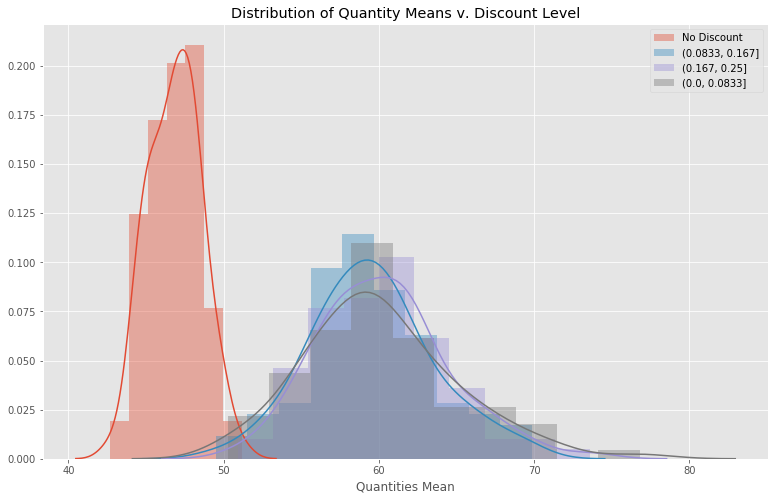

In [15]:
plt.figure(figsize= figsize)
plt.title('Distribution of Quantity Means v. Discount Level')
plt.xlabel('Quantity')
for i in df_orders.BinnedDiscount.value_counts().index:
    
    sns.distplot(df_order_means[i], label= i,axlabel='Quantities Mean')
    plt.legend()


#### Check for normality- Sharpio-Welk test

In [16]:
for i in df_orders.BinnedDiscount.value_counts().index:
    print(i)
    print(func.shapiro_normal(df_order_means[i]))

No Discount
normal
t 0.989066481590271, p 0.6916583776473999
(0.0833, 0.167]
normal
t 0.9910159707069397, p 0.8244869709014893
(0.167, 0.25]
normal
t 0.9828118085861206, p 0.31041231751441956
(0.0, 0.0833]
normal
t 0.9735333919525146, p 0.0743236392736435


#### Test analysis
The null hypothesis is that the tested distribution is normally distributed, and the alternative hypothesis is that the distribution is non-normal. A p values threshold is 0.05. 

The p values for the bootstrap order data are above 0.05, so they are normal. 


#### Variance Test

In [17]:
for i in df_orders.BinnedDiscount.value_counts().index:
    print(f"No Discount compared to {i}")
    print(func.levene_variances(df_order_means['No Discount'], df_order_means[i]))



No Discount compared to No Discount
p = 1.0
Therefore the data have equal variances
True
No Discount compared to (0.0833, 0.167]
p = 2.3624068890208353e-08
Therefore the data do not have equal variances
False
No Discount compared to (0.167, 0.25]
p = 1.4940850533393439e-09
Therefore the data do not have equal variances
False
No Discount compared to (0.0, 0.0833]
p = 2.2265026744071246e-09
Therefore the data do not have equal variances
False


#### Test Analysis
The null hypothesis is the variances of the two compared distribution are equal. The alternative hypothesis is the variances are not equal.

The discounted sample means do not have equal variances with the other discount distribution.

#### Effect Size

In [18]:
for i in df_orders.BinnedDiscount.value_counts().index:
    print(f"No Discount compared to {i}")
    print(func.cohen_d(df_order_means[i], df_order_means['No Discount']))

No Discount compared to No Discount
0.0
No Discount compared to (0.0833, 0.167]
4.1383338433632
No Discount compared to (0.167, 0.25]
4.19711479560407
No Discount compared to (0.0, 0.0833]
3.6021057606810687


There is a fairly large effect size for No Discount versus no discount.


###  Tukey Test

In [22]:
mc = MultiComparison(df_means.Quantity, df_means.BinnedValue)
result = mc.tukeyhsd()
result_df = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])
result_df


,group1,group2,meandiff,lower,upper,reject
0,"(0.0, 0.0833]","(0.0833, 0.167]",-0.5406,-2.0713,0.9900,False
1,"(0.0, 0.0833]","(0.167, 0.25]",0.1985,-1.3321,1.7292,False
2,"(0.0, 0.0833]",No Discount,-13.2199,-14.7506,-11.6893,True
3,"(0.0833, 0.167]","(0.167, 0.25]",0.7392,-0.7915,2.2698,False
4,"(0.0833, 0.167]",No Discount,-12.6793,-14.2099,-11.1486,True
5,"(0.167, 0.25]",No Discount,-13.4185,-14.9491,-11.8878,True


### Test Analysis
There are statistical difference in the means of the discounted order quantity versus non discounted orders. Also there was not a significant difference among the different levels of discounted orders. These results indicate that having a discount has an effect on the quantity of the purchase, but the level of the discount does not seem to have effect after discount is applied. 

In [20]:
orders_with_discount.Quantity.mean(), orders_with_no_discount.Quantity.mean(), orders_with_discount.Quantity.mean()-orders_with_no_discount.Quantity.mean()

(59.78421052631579, 46.65415986949429, 13.130050656821496)

There is a 13.1 quantity increase in the quantity with a discount. 

In [21]:
!jupyter nbconvert --to markdown question1

[NbConvertApp] Converting notebook question1.ipynb to markdown
[NbConvertApp] Support files will be in question1_files\
[NbConvertApp] Making directory question1_files
[NbConvertApp] Making directory question1_files
[NbConvertApp] Making directory question1_files
[NbConvertApp] Writing 13658 bytes to question1.md
